Carson Bauer<br>
11/20/2024<br>
Spotify Analysis Report<br>

In [3]:
import urllib
import requests
import pandas as pd
import json
import base64
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.formula.api as smf

In [4]:
def get_session_token(SessionID, SessionKey):
    url = 'https://accounts.spotify.com/api/token'
    data = {'grant_type':'client_credentials'}
    encoded_key = base64.b64encode(str(SessionID + ":" + SessionKey).\
                                   encode("ascii"))
    header = {'Authorization': 'Basic {}'.format(encoded_key.decode("ascii"))}
    
    response = requests.post(url,
                            data = data,
                            headers = header)
    print(response.status_code)
    return response.json()['access_token']

In [5]:
keys = pd.read_csv(r"C:\Users\gamec\Desktop\School\Data in Emat\Client_ID,Client_Secret.txt")

In [6]:
access_token = get_session_token(keys['Client_ID'].iloc[0], keys['Client_Secret'].iloc[0])

200


In [7]:
t_features_ep = 'https://api.spotify.com/v1/audio-features'
tracks_ep = 'https://api.spotify.com/v1/tracks/'
ab_tracks_ep = 'https://api.spotify.com/v1/albums/{}/tracks'

In [8]:
def api_call(endpoint_url, api_header):
    response = requests.get(endpoint_url, headers = api_header)
    print(response.status_code)
    return response.json()

In [9]:
session_header = {'Authorization': 'Bearer {}'.format(access_token)}

The two albums I picked are by the same artist, AJJ. I did two albums by the same band because AJJ has been my #1 band for nearly 10 years: there are periods where I don't listen to anything else. I picked these two albums specifically, because I wanted to compare the oldest album (not counting the crappy one they made in high school) and their most recent album. There are sixteen years between the two albums and they changed genres multiple times, so I think there will be a lot of differences between the two.

The oldest album, from 2007, is called "People Who Can Eat People Are The Luckiest People In The World" (from now on referred to as "People", or the acronym "PWCEPATLPITW" because it's a long title). The genre is folk punk, and it's all acoustic, just an acoustic guitar and a cello, and one track with bells. The newest album is called Disposable Everything, released in 2023, and veers towards alternative/rock. A handful of songs still use acoustic gutiar, but they are paired withs synths/studio elements. The album is mostly electric.

Because of this, I picked the attributes 'acousticness' and 'danceability'. It's my hypothesis that People will rank much higher in acousticness, but Disposable Everything will rank higher in danceability. In my head, because it's more polished it's more danceable. But Spotify measures danceability from "tempo, rhythm stability, beat strength, and overall regularity", so I'm not sure how it will fare. Since People is so stripped down/has less instruments, it likely scores higher on the regularity chart, so I'm not 100% confident in my hypothesis, so I'd like to see.

In [10]:
de_album_id = '0uDWPhORO8SgKok6AuEyAc'
ppl_album_id = '7GD68eErLeQn0TCJQ6hjOz'

In [11]:
de_album_response = api_call(ab_tracks_ep.format(de_album_id), session_header)
ppl_album_response = api_call(ab_tracks_ep.format(ppl_album_id), session_header)

200
200


In [12]:
de_album_df = pd.DataFrame(de_album_response['items'])
ppl_album_df = pd.DataFrame(ppl_album_response['items'])

In [13]:
de_track_ids = ','.join(de_album_df['id'].to_list())
ppl_track_ids = ','.join(ppl_album_df['id'].to_list())

In [14]:
de_track_features = api_call(t_features_ep + '?ids={}'.format(de_track_ids), session_header)
ppl_track_features = api_call(t_features_ep + '?ids={}'.format(ppl_track_ids), session_header)

200
200


In [15]:
de_track_info = api_call(tracks_ep + '?market=US&ids={}'.format(de_track_ids), session_header)
ppl_track_info = api_call(tracks_ep + '?market=US&ids={}'.format(ppl_track_ids), session_header)

200
200


In [16]:
de_features_df = pd.DataFrame(de_track_features['audio_features'])
ppl_features_df = pd.DataFrame(ppl_track_features['audio_features'])
# de_features_df.head()

In [17]:
de_tracks_df = pd.DataFrame(de_track_info['tracks'])
ppl_tracks_df = pd.DataFrame(ppl_track_info['tracks'])
# de_tracks_df.head()

In [18]:
de_merged = pd.merge(de_features_df, de_tracks_df, how = 'inner', on = 'id')
ppl_merged = pd.merge(ppl_features_df, ppl_tracks_df, how = 'inner', on = 'id')

In [19]:
de_merged['ARTIST'] = "AJJ"
ppl_merged['ARTIST'] = "AJJ"

de_merged['album_name'] = "Disposable Everything"
ppl_merged['album_name'] = "PWCEPATLPITW"
de_merged.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type_x', 'id', 'uri_x', 'track_href', 'analysis_url', 'duration_ms_x',
       'time_signature', 'album', 'artists', 'disc_number', 'duration_ms_y',
       'explicit', 'external_ids', 'external_urls', 'href', 'is_local',
       'is_playable', 'name', 'popularity', 'preview_url', 'track_number',
       'type_y', 'uri_y', 'ARTIST', 'album_name'],
      dtype='object')

In [20]:
artist_compare = pd.concat([de_merged, ppl_merged], axis = 0)
artist_compare.columns
artist_compare.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,is_local,is_playable,name,popularity,preview_url,track_number,type_y,uri_y,ARTIST,album_name
0,0.321,0.919,9,-9.205,1,0.0557,0.000149,0.369000,0.225,0.2200,...,False,True,Strawberry (Probably),28,https://p.scdn.co/mp3-preview/6ff04b2d0b445ab1...,1,track,spotify:track:0QZ10VC3xe0IsUcWBejgtF,AJJ,Disposable Everything
1,0.633,0.857,7,-7.729,1,0.0602,0.202000,0.000179,0.382,0.9010,...,False,True,Dissonance,32,https://p.scdn.co/mp3-preview/5166e2f96112b2ab...,2,track,spotify:track:7mOD2D8wpU4X5XgZS0dhTA,AJJ,Disposable Everything
2,0.518,0.413,7,-12.649,1,0.0403,0.080300,0.000116,0.123,0.1030,...,False,True,Moon Valley High,22,https://p.scdn.co/mp3-preview/a5ad9f9f8a092b13...,3,track,spotify:track:1OiBZnLnpQdKWTk0U4OpVL,AJJ,Disposable Everything
3,0.410,0.931,7,-8.551,1,0.1380,0.037200,0.000000,0.440,0.2570,...,False,True,Death Machine,32,https://p.scdn.co/mp3-preview/b9e6f6ca71abd08c...,4,track,spotify:track:1MTOmUqUo4RD6fEuQqurS6,AJJ,Disposable Everything
4,0.383,0.312,0,-11.425,1,0.0269,0.361000,0.000063,0.222,0.0885,...,False,True,White Ghosts,23,https://p.scdn.co/mp3-preview/8c26bc4b834d9240...,5,track,spotify:track:5tYum1D7tCVPCNuvWzSmOT,AJJ,Disposable Everything


Since the titles are so long, I just set them as variables so I wouldn't have to re-type it all the time. I noticed with the legends that it's still quite long, and I had to make the graphs really wide to compensate, so I considered a second variable to shorten it. For now I think it's okay.

In [21]:
de = "Disposable Everything"
ppl = "PWCEPATLPITW"

Immediately I'm realizing I was wrong about both of my hypotheses. Overall acousticness is about the same, but there are two significant outliers as seen here. 

In [22]:
de_merged[de_merged['acousticness'] > .3][['album_name', 'album_name', 'acousticness']]

,album_name,album_name,acousticness
4,Disposable Everything,Disposable Everything,0.361
5,Disposable Everything,Disposable Everything,0.747
13,Disposable Everything,Disposable Everything,0.740


The averages are relatively close as well. Still slightly higher on People, but not high enough to make any judgements from.

In [23]:
de_average = sum(de_merged['acousticness']) / len(de_merged['acousticness'])
print('Average Disposable Everything acousticness: ', de_average)

ppl_average = sum(ppl_merged['acousticness']) / len(ppl_merged['acousticness'])
print('Average People acousticness: ', ppl_average)

Average Disposable Everything acousticness:  0.17861792857142858
Average People acousticness:  0.2641818181818182


On danceability as well, even if it was an even split, I really expected Disposable Everything to take the lead. The average danceability of People is higher as well, by almost 0.1.

In [24]:
de_average_2 = sum(de_merged['danceability']) / len(de_merged['danceability'])
print('Average Disposable Everything danceability: ', de_average)

ppl_average_2 = sum(ppl_merged['danceability']) / len(ppl_merged['danceability'])
print('Average People danceability: ', ppl_average)

Average Disposable Everything danceability:  0.17861792857142858
Average People danceability:  0.2641818181818182


There's a small enough number of data points in these sets that I felt okay not setting it into a certain amount of bins. Since we aren't looking at the two graphs in comparison to one another, I decided not to use the sharex feature. But since we are looking at the number of songs, I used the sharey, since the two graphs next to each other are a little tough to interpret with different scales.

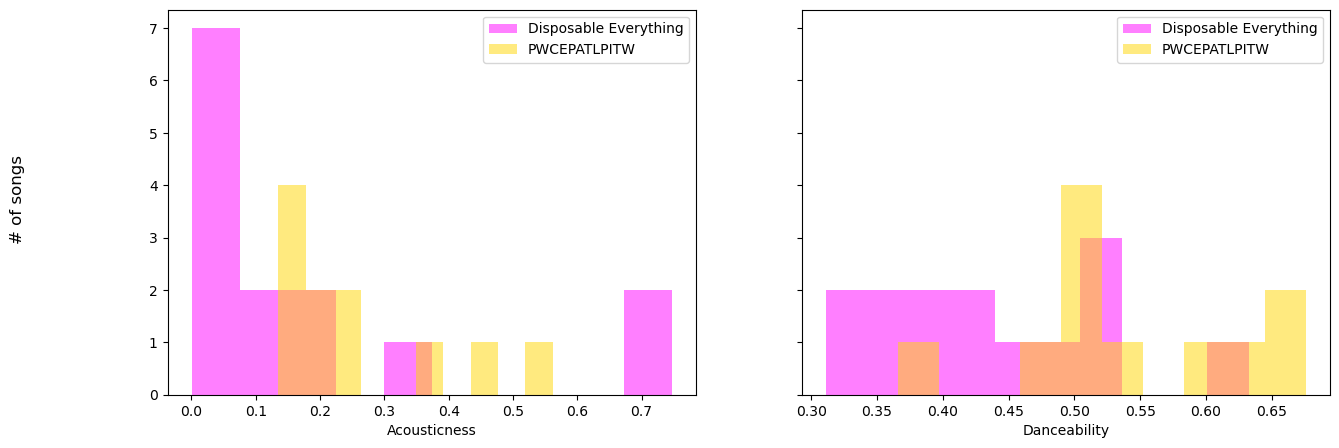

In [25]:
fig1, ax1 = plt.subplots(1,2, figsize = (15,5), sharey = True)
ax1[0].hist(de_merged['acousticness'], alpha = 0.5, color = 'magenta')
ax1[0].hist(ppl_merged['acousticness'], alpha = 0.5, color = 'gold')
ax1[0].set_xlabel('Acousticness')

ax1[1].hist(de_merged['danceability'], alpha = 0.5, color = 'magenta')
ax1[1].hist(ppl_merged['danceability'], alpha = 0.5, color = 'gold')
ax1[1].set_xlabel('Danceability')

fig1.supylabel('# of songs')

ax1[0].legend([de, ppl])
ax1[1].legend([de, ppl])

plt.show()

You can really see the disparity in acousticness in this graph. Even if there were outliers, I expected all of Disposable Everything to trail relatively behind People. As well, you can see how heavy People is towards the upper scale of danceability.

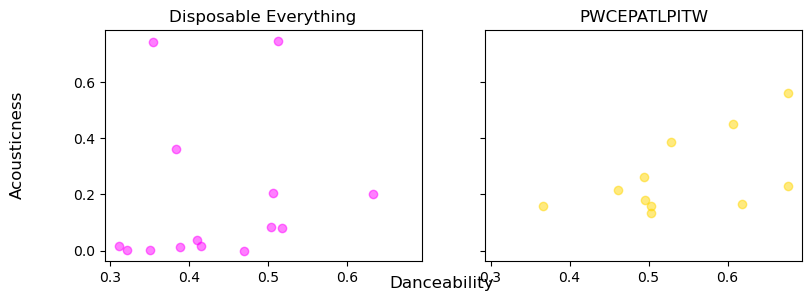

In [26]:
fig2, ax2 = plt.subplots(1,2, figsize = (9,3), sharex = True, sharey= True)
ax2[0].scatter(de_merged['danceability'], de_merged['acousticness'], alpha = 0.5, color = 'magenta')
ax2[1].scatter(ppl_merged['danceability'], ppl_merged['acousticness'], alpha = 0.5, color = 'gold')

ax2[0].set_title(de)
ax2[1].set_title(ppl)

fig2.supxlabel('Danceability')
fig2.supylabel('Acousticness')
plt.show()

Here are the two graphs laid overtop one another. Disposable Everything is (very relatively) homogenous with some extreme outliers, compared to People which is spread throughout the area.

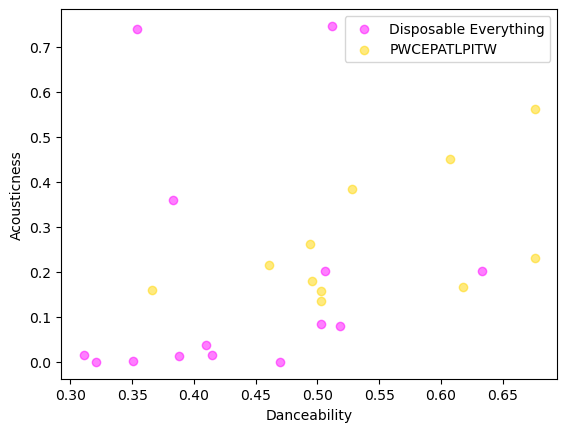

In [27]:
fig3, ax3 = plt.subplots()
line1 = ax3.scatter(de_merged['danceability'], de_merged['acousticness'], alpha = 0.5, color = 'magenta', label = 'Disposable Everything')
line2 = ax3.scatter(ppl_merged['danceability'], ppl_merged['acousticness'], alpha = 0.5, color = 'gold', label = 'PWCEPATLPITW')

ax3.legend(handles = [line1, line2])

ax3.set_xlabel('Danceability')
ax3.set_ylabel('Acousticness')
plt.show()

They aren't very extreme outliers, but Disposable Everything's outliers are seen here, even with danceability (with less extreme outliers than acousticness). You can also see the relative homogeneity of People's tracks with how low the median in the box. This makes sense with how stripped down the album, it's hard to get extreme variance with only two instruments.

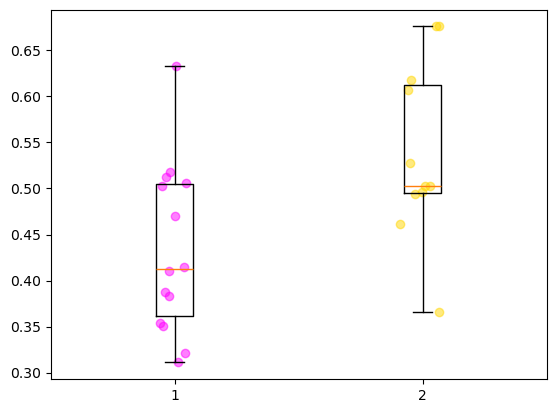

In [28]:
de_danceability = de_merged['danceability']
ppl_danceability = ppl_merged['danceability']
de_xs = [1] * len(de_danceability)
ppl_xs = [2] * len(ppl_danceability)
de_x_jitter = np.random.uniform(-0.10, .10, len(de_xs))
ppl_x_jitter = np.random.uniform(-.10, .10, len(ppl_xs))

fig2, ax2 = plt.subplots()
ax2.boxplot(de_danceability, positions = [1])
ax2.boxplot(ppl_danceability, positions = [2])
ax2.scatter(de_xs + de_x_jitter, de_danceability, alpha = .5, color = 'magenta')
ax2.scatter(ppl_xs + ppl_x_jitter, ppl_danceability, alpha = .5, color = 'gold')


plt.show()

The R value for danceability is so low, it's not really possible to rank an album as significantly more danceable.

In [31]:
model1 = smf.ols('danceability ~ album_name', data = artist_compare).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           danceability   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     7.737
Date:                Fri, 22 Nov 2024   Prob (F-statistic):             0.0106
Time:                        23:27:36   Log-Likelihood:                 24.767
No. Observations:                  25   AIC:                            -45.53
Df Residuals:                      23   BIC:                            -43.10
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.4339      0.025     17.332      0.000       0.382       0.486
album_name[T.PWCEPATLPITW]     0.1050      0.038      2.781      0.011       0.027       0.183
==============================================================================
Omnibus:                        0.630   Durbin-Watson:                   2.285
Prob(Omnibus):                  0.730   Jarque-Bera (JB):                0.711
Skew:                           0.283   Prob(JB):                        0.701
Kurtosis:                       2.399   Cond. No.                         2.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This R value is shockingly low for this table as as well, I'm really surprised. I expected there to be at least a slight amount of correlation between album and value.

In [30]:
model1 = smf.ols('acousticness ~ album_name', data = artist_compare).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           acousticness   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9568
Date:                Fri, 22 Nov 2024   Prob (F-statistic):              0.338
Time:                        23:27:25   Log-Likelihood:                 3.7526
No. Observations:                  25   AIC:                            -3.505
Df Residuals:                      23   BIC:                            -1.068
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.1786      0.058      3.078      0.005       0.059       0.299
album_name[T.PWCEPATLPITW]     0.0856      0.087      0.978      0.338      -0.095       0.267
==============================================================================
Omnibus:                       14.302   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.594
Skew:                           1.596   Prob(JB):                      0.00112
Kurtosis:                       4.690   Cond. No.                         2.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

I'm really surprised with the data. I expected People to be very acoustic and not very danceable, but it turns out the values were mostly equal across albums. I found it interesting as well that most of the values were 0.5 or under, and it was only outliers who went above that number. I think it's really interesting how a person's perception is so different from the algorithms Spotify uses to rate music, and how that could affect the playlists that Spotify automatically generates. I would want to listen to albums that Spotify ranks as very acoustic and not very danceable to compare it to People, because it would be interesting to see what it actually sounds like. Overall, my hypotheses were incorrect.